In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, 1.0, 1.0)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset_scaled.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV3(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )

        self.conv0 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        x = F.relu(self.conv0(x))
        cloud_mask_pred = self.cloud_mask_net(x)
        cloud_phase_pred = self.cloud_phase_net(x)
        cod_pred = self.cod_net(x)
        cps_pred = self.cps_net(x)

        cloud_phase_pred = torch.cat([cloud_mask_pred, cloud_phase_pred], dim=1)
        cod_pred = torch.cat([cloud_mask_pred, cod_pred], dim=1)
        cps_pred = torch.cat([cloud_mask_pred, cps_pred], dim=1)

        cloud_phase_pred = F.relu(self.conv1(cloud_phase_pred))
        cod_pred = F.relu(self.conv2(cod_pred))
        cps_pred = F.relu(self.conv3(cps_pred))

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred



In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV3().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")
    

100%|██████████| 94/94 [00:29<00:00,  3.17it/s]


Epoch: 1 | Train Loss: 11.0491 | Val Loss: 8.0906 | Val Mask: 0.8373 | Val Phase: 0.6247 | Val Cod: -0.0213 | Val Cps: -1.2981


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 2 | Train Loss: 8.0490 | Val Loss: 6.6424 | Val Mask: 0.7867 | Val Phase: 0.6513 | Val Cod: 0.2449 | Val Cps: -0.8254


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 3 | Train Loss: 5.9711 | Val Loss: 4.2021 | Val Mask: 0.8918 | Val Phase: 0.7620 | Val Cod: 0.4689 | Val Cps: -0.0512


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 4 | Train Loss: 4.0909 | Val Loss: 3.7916 | Val Mask: 0.8997 | Val Phase: 0.7427 | Val Cod: 0.0358 | Val Cps: 0.3273


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 5 | Train Loss: 2.8075 | Val Loss: 3.3002 | Val Mask: 0.8632 | Val Phase: 0.7441 | Val Cod: 0.4843 | Val Cps: 0.3126


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 6 | Train Loss: 2.2395 | Val Loss: 2.6862 | Val Mask: 0.8931 | Val Phase: 0.8051 | Val Cod: 0.5546 | Val Cps: 0.4514


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 7 | Train Loss: 2.0244 | Val Loss: 3.5883 | Val Mask: 0.8066 | Val Phase: 0.6149 | Val Cod: 0.4867 | Val Cps: 0.3475


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 8 | Train Loss: 1.8989 | Val Loss: 2.3983 | Val Mask: 0.8378 | Val Phase: 0.7952 | Val Cod: 0.6523 | Val Cps: 0.5711


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 9 | Train Loss: 1.8197 | Val Loss: 2.5005 | Val Mask: 0.9239 | Val Phase: 0.8238 | Val Cod: 0.6435 | Val Cps: 0.4194


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 10 | Train Loss: 1.7370 | Val Loss: 2.0046 | Val Mask: 0.9354 | Val Phase: 0.8193 | Val Cod: 0.6489 | Val Cps: 0.6315


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 11 | Train Loss: 1.6846 | Val Loss: 2.5717 | Val Mask: 0.8925 | Val Phase: 0.8165 | Val Cod: 0.5974 | Val Cps: 0.4409


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 12 | Train Loss: 1.6338 | Val Loss: 2.3544 | Val Mask: 0.9431 | Val Phase: 0.8312 | Val Cod: 0.6077 | Val Cps: 0.4661


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 13 | Train Loss: 1.5914 | Val Loss: 2.0447 | Val Mask: 0.8839 | Val Phase: 0.8152 | Val Cod: 0.6558 | Val Cps: 0.6502


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 14 | Train Loss: 1.5441 | Val Loss: 2.3140 | Val Mask: 0.9316 | Val Phase: 0.8404 | Val Cod: 0.5935 | Val Cps: 0.4859


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 15 | Train Loss: 1.5134 | Val Loss: 1.7172 | Val Mask: 0.9508 | Val Phase: 0.8364 | Val Cod: 0.6966 | Val Cps: 0.6733


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 16 | Train Loss: 1.4624 | Val Loss: 1.7529 | Val Mask: 0.9394 | Val Phase: 0.8360 | Val Cod: 0.6331 | Val Cps: 0.6958


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 17 | Train Loss: 1.4343 | Val Loss: 2.0390 | Val Mask: 0.9472 | Val Phase: 0.8237 | Val Cod: 0.6364 | Val Cps: 0.5850


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 18 | Train Loss: 1.4138 | Val Loss: 2.1412 | Val Mask: 0.9447 | Val Phase: 0.8312 | Val Cod: 0.6634 | Val Cps: 0.5192


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 19 | Train Loss: 1.3819 | Val Loss: 1.9017 | Val Mask: 0.9399 | Val Phase: 0.8233 | Val Cod: 0.5816 | Val Cps: 0.6635


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 20 | Train Loss: 1.3529 | Val Loss: 1.8014 | Val Mask: 0.9525 | Val Phase: 0.8418 | Val Cod: 0.7144 | Val Cps: 0.6105


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 21 | Train Loss: 1.3357 | Val Loss: 1.7726 | Val Mask: 0.9431 | Val Phase: 0.8270 | Val Cod: 0.6277 | Val Cps: 0.6871


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 22 | Train Loss: 1.3129 | Val Loss: 1.6540 | Val Mask: 0.9398 | Val Phase: 0.8555 | Val Cod: 0.6414 | Val Cps: 0.7022


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 23 | Train Loss: 1.2899 | Val Loss: 1.7313 | Val Mask: 0.9482 | Val Phase: 0.8445 | Val Cod: 0.6765 | Val Cps: 0.6537


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 24 | Train Loss: 1.2735 | Val Loss: 1.5838 | Val Mask: 0.9487 | Val Phase: 0.8470 | Val Cod: 0.7088 | Val Cps: 0.6994


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 25 | Train Loss: 1.2587 | Val Loss: 1.7586 | Val Mask: 0.9393 | Val Phase: 0.8446 | Val Cod: 0.6444 | Val Cps: 0.6702


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 26 | Train Loss: 1.2378 | Val Loss: 1.7549 | Val Mask: 0.9268 | Val Phase: 0.8213 | Val Cod: 0.6784 | Val Cps: 0.6891


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 27 | Train Loss: 1.2187 | Val Loss: 1.5642 | Val Mask: 0.9399 | Val Phase: 0.8481 | Val Cod: 0.7153 | Val Cps: 0.7129


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 28 | Train Loss: 1.2079 | Val Loss: 1.5037 | Val Mask: 0.9574 | Val Phase: 0.8582 | Val Cod: 0.7005 | Val Cps: 0.7202


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 29 | Train Loss: 1.1912 | Val Loss: 1.5167 | Val Mask: 0.9545 | Val Phase: 0.8541 | Val Cod: 0.6961 | Val Cps: 0.7168


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 30 | Train Loss: 1.1929 | Val Loss: 1.4782 | Val Mask: 0.9552 | Val Phase: 0.8566 | Val Cod: 0.7172 | Val Cps: 0.7210


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 31 | Train Loss: 1.1671 | Val Loss: 1.5483 | Val Mask: 0.9531 | Val Phase: 0.8499 | Val Cod: 0.7107 | Val Cps: 0.7003


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 32 | Train Loss: 1.1555 | Val Loss: 1.4548 | Val Mask: 0.9550 | Val Phase: 0.8663 | Val Cod: 0.7158 | Val Cps: 0.7204


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 33 | Train Loss: 1.1367 | Val Loss: 1.6360 | Val Mask: 0.9523 | Val Phase: 0.8187 | Val Cod: 0.6728 | Val Cps: 0.7228


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 34 | Train Loss: 1.1317 | Val Loss: 1.5813 | Val Mask: 0.9582 | Val Phase: 0.8593 | Val Cod: 0.6211 | Val Cps: 0.7225


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 35 | Train Loss: 1.1273 | Val Loss: 1.4663 | Val Mask: 0.9578 | Val Phase: 0.8497 | Val Cod: 0.7217 | Val Cps: 0.7245


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 36 | Train Loss: 1.1150 | Val Loss: 1.4288 | Val Mask: 0.9561 | Val Phase: 0.8617 | Val Cod: 0.7195 | Val Cps: 0.7324


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 37 | Train Loss: 1.0931 | Val Loss: 1.3905 | Val Mask: 0.9568 | Val Phase: 0.8683 | Val Cod: 0.7344 | Val Cps: 0.7366


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 38 | Train Loss: 1.0829 | Val Loss: 1.6300 | Val Mask: 0.9607 | Val Phase: 0.7799 | Val Cod: 0.7128 | Val Cps: 0.7378


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 39 | Train Loss: 1.0787 | Val Loss: 1.5357 | Val Mask: 0.9572 | Val Phase: 0.8683 | Val Cod: 0.7434 | Val Cps: 0.6635


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 40 | Train Loss: 1.0688 | Val Loss: 1.5128 | Val Mask: 0.9603 | Val Phase: 0.8383 | Val Cod: 0.7205 | Val Cps: 0.7121


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 41 | Train Loss: 1.0685 | Val Loss: 1.4240 | Val Mask: 0.9626 | Val Phase: 0.8482 | Val Cod: 0.7434 | Val Cps: 0.7267


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 42 | Train Loss: 1.0570 | Val Loss: 1.4229 | Val Mask: 0.9615 | Val Phase: 0.8639 | Val Cod: 0.6984 | Val Cps: 0.7370


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 43 | Train Loss: 1.0514 | Val Loss: 1.4275 | Val Mask: 0.9606 | Val Phase: 0.8571 | Val Cod: 0.7239 | Val Cps: 0.7258


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 44 | Train Loss: 1.0407 | Val Loss: 1.4155 | Val Mask: 0.9621 | Val Phase: 0.8662 | Val Cod: 0.7043 | Val Cps: 0.7336


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 45 | Train Loss: 1.0281 | Val Loss: 1.4492 | Val Mask: 0.9623 | Val Phase: 0.8306 | Val Cod: 0.7268 | Val Cps: 0.7484


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 46 | Train Loss: 1.0226 | Val Loss: 1.3424 | Val Mask: 0.9604 | Val Phase: 0.8695 | Val Cod: 0.7374 | Val Cps: 0.7478


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 47 | Train Loss: 1.0161 | Val Loss: 1.3474 | Val Mask: 0.9633 | Val Phase: 0.8687 | Val Cod: 0.7466 | Val Cps: 0.7451


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 48 | Train Loss: 1.0045 | Val Loss: 1.3868 | Val Mask: 0.9620 | Val Phase: 0.8710 | Val Cod: 0.7141 | Val Cps: 0.7336


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 49 | Train Loss: 1.0010 | Val Loss: 1.3614 | Val Mask: 0.9607 | Val Phase: 0.8683 | Val Cod: 0.7381 | Val Cps: 0.7383


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 50 | Train Loss: 0.9961 | Val Loss: 1.3714 | Val Mask: 0.9623 | Val Phase: 0.8681 | Val Cod: 0.7289 | Val Cps: 0.7413


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 51 | Train Loss: 0.9871 | Val Loss: 1.2917 | Val Mask: 0.9629 | Val Phase: 0.8749 | Val Cod: 0.7517 | Val Cps: 0.7516


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 52 | Train Loss: 0.9913 | Val Loss: 1.3841 | Val Mask: 0.9639 | Val Phase: 0.8724 | Val Cod: 0.7323 | Val Cps: 0.7258


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 53 | Train Loss: 0.9830 | Val Loss: 1.3355 | Val Mask: 0.9649 | Val Phase: 0.8757 | Val Cod: 0.7136 | Val Cps: 0.7489


100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Epoch: 54 | Train Loss: 0.9770 | Val Loss: 1.3668 | Val Mask: 0.9640 | Val Phase: 0.8697 | Val Cod: 0.7472 | Val Cps: 0.7279


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 55 | Train Loss: 0.9720 | Val Loss: 1.5096 | Val Mask: 0.9526 | Val Phase: 0.8511 | Val Cod: 0.7318 | Val Cps: 0.7245


100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Epoch: 56 | Train Loss: 0.9702 | Val Loss: 1.3849 | Val Mask: 0.9633 | Val Phase: 0.8754 | Val Cod: 0.7424 | Val Cps: 0.7207


100%|██████████| 94/94 [00:26<00:00,  3.62it/s]


Epoch: 57 | Train Loss: 0.9625 | Val Loss: 1.4187 | Val Mask: 0.9602 | Val Phase: 0.8638 | Val Cod: 0.7378 | Val Cps: 0.7383


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 58 | Train Loss: 0.9472 | Val Loss: 1.3214 | Val Mask: 0.9649 | Val Phase: 0.8724 | Val Cod: 0.7542 | Val Cps: 0.7478


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 59 | Train Loss: 0.9483 | Val Loss: 1.3174 | Val Mask: 0.9651 | Val Phase: 0.8702 | Val Cod: 0.7561 | Val Cps: 0.7431


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 60 | Train Loss: 0.9484 | Val Loss: 1.3021 | Val Mask: 0.9650 | Val Phase: 0.8777 | Val Cod: 0.7533 | Val Cps: 0.7454


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 61 | Train Loss: 0.9443 | Val Loss: 1.5508 | Val Mask: 0.9609 | Val Phase: 0.8424 | Val Cod: 0.6953 | Val Cps: 0.7039


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 62 | Train Loss: 0.9340 | Val Loss: 1.3501 | Val Mask: 0.9649 | Val Phase: 0.8699 | Val Cod: 0.7442 | Val Cps: 0.7359


100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


Epoch: 63 | Train Loss: 0.9330 | Val Loss: 1.3550 | Val Mask: 0.9638 | Val Phase: 0.8730 | Val Cod: 0.7405 | Val Cps: 0.7312


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 64 | Train Loss: 0.9251 | Val Loss: 1.3220 | Val Mask: 0.9626 | Val Phase: 0.8640 | Val Cod: 0.7547 | Val Cps: 0.7568


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 65 | Train Loss: 0.9279 | Val Loss: 1.3040 | Val Mask: 0.9631 | Val Phase: 0.8718 | Val Cod: 0.7402 | Val Cps: 0.7516


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 66 | Train Loss: 0.9225 | Val Loss: 1.5256 | Val Mask: 0.9663 | Val Phase: 0.8749 | Val Cod: 0.7587 | Val Cps: 0.6435


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 67 | Train Loss: 0.9150 | Val Loss: 1.2881 | Val Mask: 0.9635 | Val Phase: 0.8745 | Val Cod: 0.7564 | Val Cps: 0.7611


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 68 | Train Loss: 0.9141 | Val Loss: 1.2963 | Val Mask: 0.9665 | Val Phase: 0.8687 | Val Cod: 0.7594 | Val Cps: 0.7468


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 69 | Train Loss: 0.9073 | Val Loss: 1.2991 | Val Mask: 0.9613 | Val Phase: 0.8649 | Val Cod: 0.7543 | Val Cps: 0.7591


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 70 | Train Loss: 0.9039 | Val Loss: 1.2953 | Val Mask: 0.9657 | Val Phase: 0.8763 | Val Cod: 0.7442 | Val Cps: 0.7540


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 71 | Train Loss: 0.8982 | Val Loss: 1.2518 | Val Mask: 0.9658 | Val Phase: 0.8755 | Val Cod: 0.7534 | Val Cps: 0.7660


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 72 | Train Loss: 0.8939 | Val Loss: 1.2666 | Val Mask: 0.9651 | Val Phase: 0.8760 | Val Cod: 0.7533 | Val Cps: 0.7561


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 73 | Train Loss: 0.8939 | Val Loss: 1.2559 | Val Mask: 0.9651 | Val Phase: 0.8776 | Val Cod: 0.7571 | Val Cps: 0.7616


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 74 | Train Loss: 0.8922 | Val Loss: 1.2438 | Val Mask: 0.9667 | Val Phase: 0.8809 | Val Cod: 0.7549 | Val Cps: 0.7646


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 75 | Train Loss: 0.8835 | Val Loss: 1.4428 | Val Mask: 0.9665 | Val Phase: 0.8603 | Val Cod: 0.7636 | Val Cps: 0.7267


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 76 | Train Loss: 0.8772 | Val Loss: 1.4022 | Val Mask: 0.9579 | Val Phase: 0.8611 | Val Cod: 0.7541 | Val Cps: 0.7445


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 77 | Train Loss: 0.8732 | Val Loss: 1.2693 | Val Mask: 0.9662 | Val Phase: 0.8795 | Val Cod: 0.7540 | Val Cps: 0.7533


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 78 | Train Loss: 0.8765 | Val Loss: 1.3004 | Val Mask: 0.9657 | Val Phase: 0.8727 | Val Cod: 0.7645 | Val Cps: 0.7473


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 79 | Train Loss: 0.8803 | Val Loss: 1.3935 | Val Mask: 0.9607 | Val Phase: 0.8776 | Val Cod: 0.7608 | Val Cps: 0.7068


100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch: 80 | Train Loss: 0.8687 | Val Loss: 1.3053 | Val Mask: 0.9670 | Val Phase: 0.8767 | Val Cod: 0.7532 | Val Cps: 0.7510


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 81 | Train Loss: 0.8611 | Val Loss: 1.2713 | Val Mask: 0.9664 | Val Phase: 0.8785 | Val Cod: 0.7520 | Val Cps: 0.7624


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 82 | Train Loss: 0.8881 | Val Loss: 1.7058 | Val Mask: 0.9281 | Val Phase: 0.8410 | Val Cod: 0.7419 | Val Cps: 0.6895


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 83 | Train Loss: 0.8899 | Val Loss: 1.3054 | Val Mask: 0.9647 | Val Phase: 0.8660 | Val Cod: 0.7575 | Val Cps: 0.7545


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 84 | Train Loss: 0.8645 | Val Loss: 1.2352 | Val Mask: 0.9664 | Val Phase: 0.8809 | Val Cod: 0.7553 | Val Cps: 0.7696


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 85 | Train Loss: 0.8604 | Val Loss: 1.3393 | Val Mask: 0.9599 | Val Phase: 0.8693 | Val Cod: 0.7501 | Val Cps: 0.7440


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 86 | Train Loss: 0.8674 | Val Loss: 1.2306 | Val Mask: 0.9677 | Val Phase: 0.8737 | Val Cod: 0.7561 | Val Cps: 0.7715


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 87 | Train Loss: 0.8534 | Val Loss: 1.2811 | Val Mask: 0.9680 | Val Phase: 0.8728 | Val Cod: 0.7457 | Val Cps: 0.7698


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 88 | Train Loss: 0.8471 | Val Loss: 1.3936 | Val Mask: 0.9667 | Val Phase: 0.8628 | Val Cod: 0.7247 | Val Cps: 0.7675


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 89 | Train Loss: 0.8504 | Val Loss: 1.2649 | Val Mask: 0.9678 | Val Phase: 0.8646 | Val Cod: 0.7622 | Val Cps: 0.7646


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 90 | Train Loss: 0.8416 | Val Loss: 1.2644 | Val Mask: 0.9674 | Val Phase: 0.8813 | Val Cod: 0.7637 | Val Cps: 0.7485


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 91 | Train Loss: 0.8369 | Val Loss: 1.2261 | Val Mask: 0.9679 | Val Phase: 0.8828 | Val Cod: 0.7603 | Val Cps: 0.7688


100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Epoch: 92 | Train Loss: 0.8352 | Val Loss: 1.2642 | Val Mask: 0.9663 | Val Phase: 0.8775 | Val Cod: 0.7622 | Val Cps: 0.7639


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 93 | Train Loss: 0.8333 | Val Loss: 1.3569 | Val Mask: 0.9667 | Val Phase: 0.8794 | Val Cod: 0.7475 | Val Cps: 0.7184


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 94 | Train Loss: 0.8299 | Val Loss: 1.2973 | Val Mask: 0.9677 | Val Phase: 0.8761 | Val Cod: 0.7669 | Val Cps: 0.7358


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 95 | Train Loss: 0.8285 | Val Loss: 1.2636 | Val Mask: 0.9669 | Val Phase: 0.8815 | Val Cod: 0.7652 | Val Cps: 0.7523


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 96 | Train Loss: 0.8249 | Val Loss: 1.3648 | Val Mask: 0.9666 | Val Phase: 0.8754 | Val Cod: 0.7647 | Val Cps: 0.7280


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 97 | Train Loss: 0.8234 | Val Loss: 1.2558 | Val Mask: 0.9680 | Val Phase: 0.8796 | Val Cod: 0.7505 | Val Cps: 0.7598


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 98 | Train Loss: 0.8285 | Val Loss: 1.2038 | Val Mask: 0.9684 | Val Phase: 0.8713 | Val Cod: 0.7718 | Val Cps: 0.7770


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 99 | Train Loss: 0.8189 | Val Loss: 1.2467 | Val Mask: 0.9670 | Val Phase: 0.8790 | Val Cod: 0.7695 | Val Cps: 0.7707


100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Epoch: 100 | Train Loss: 0.8177 | Val Loss: 1.1894 | Val Mask: 0.9688 | Val Phase: 0.8839 | Val Cod: 0.7712 | Val Cps: 0.7750


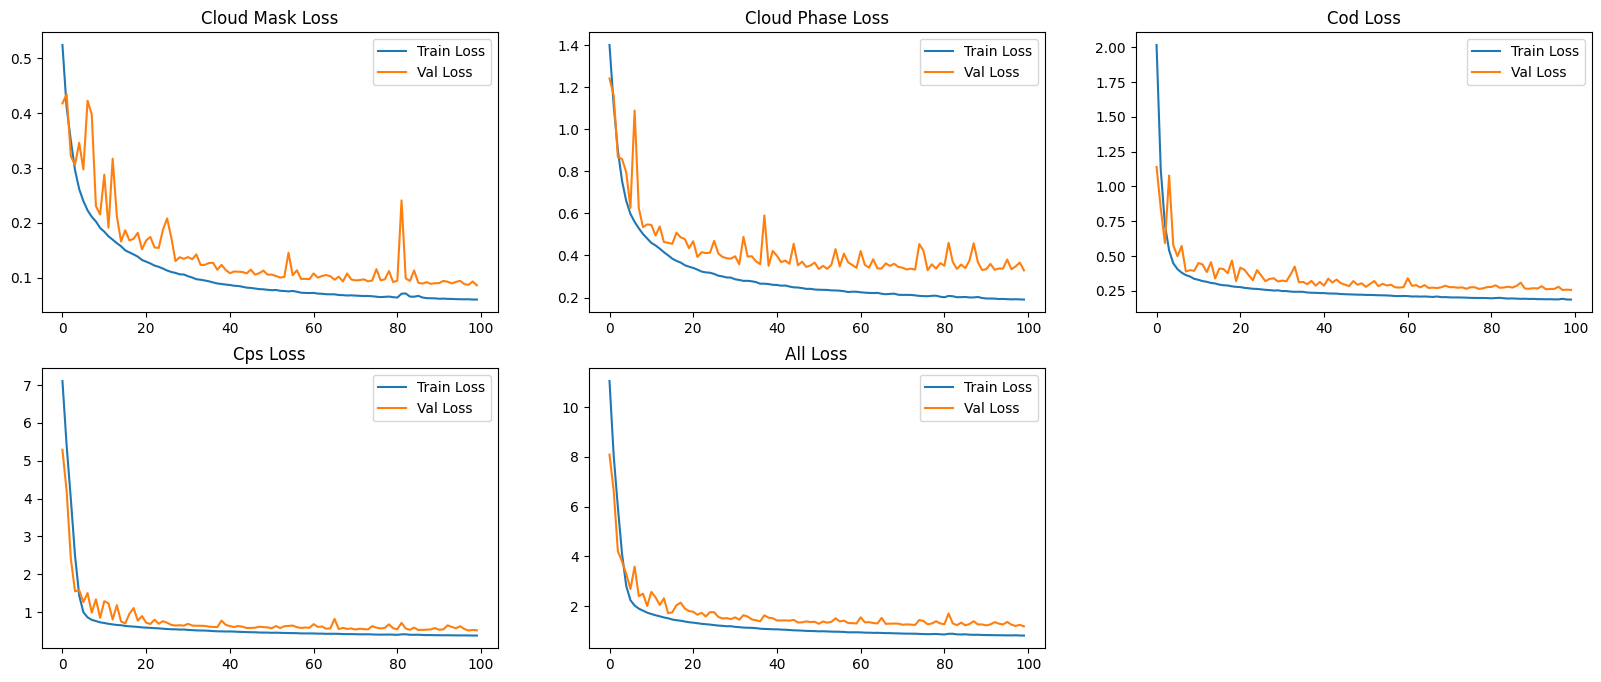

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV3_loss.png")  

plt.show()

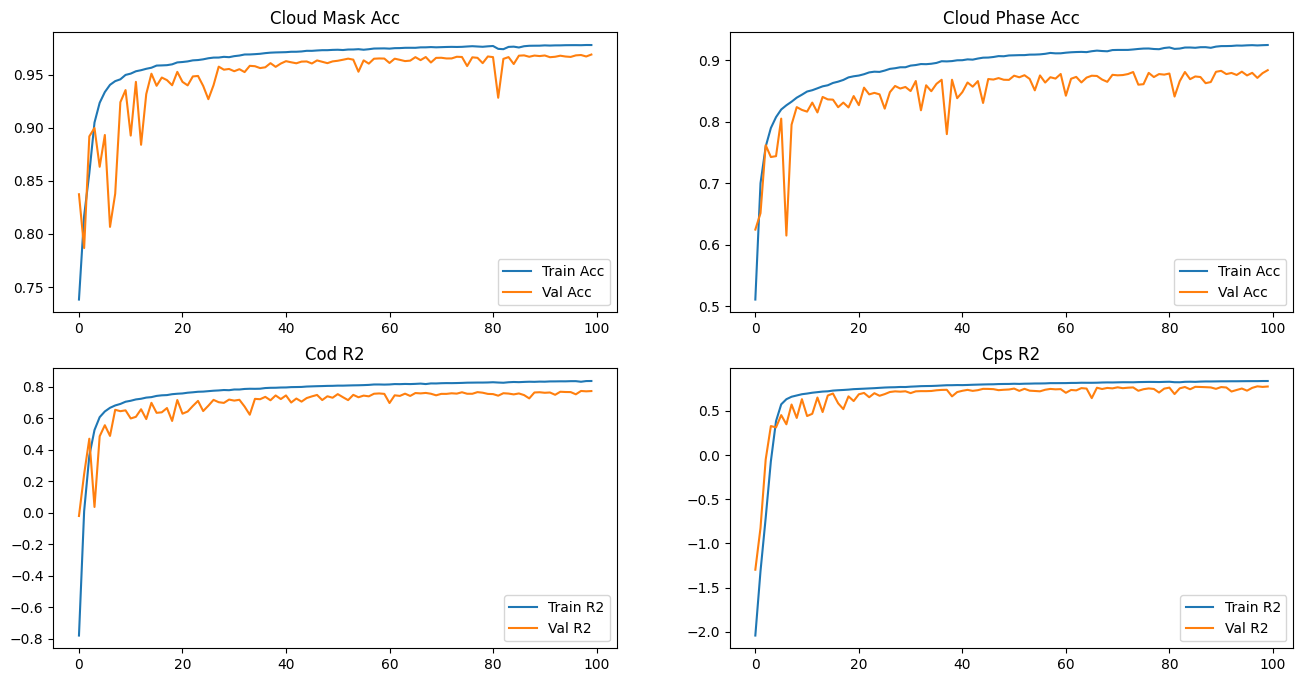

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()


plt.savefig("./graphs/MultiTaskV3_acc.png")  

plt.show()



In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:01<00:00,  6.27it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.928     0.929     0.928   5803166
           1      0.978     0.978     0.978  18740066

    accuracy                          0.966  24543232
   macro avg      0.953     0.953     0.953  24543232
weighted avg      0.966     0.966     0.966  24543232

CONFUSION MATRIX:
 [[ 5391048   412118]
 [  420530 18319536]]

IOU: [0.86621326 0.95652464]
Unweighted IoU: 0.9113689523456971
Weighted IoU: 0.9351708167144889


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  6.38it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.889     0.910     0.899   4373397
           1      0.905     0.915     0.910  10864796
           2      0.775     0.850     0.811   2400565
           3      0.540     0.454     0.493    890044
           4      0.913     0.865     0.889   6014430

    accuracy                          0.879  24543232
   macro avg      0.804     0.799     0.800  24543232
weighted avg      0.878     0.879     0.878  24543232

CONFUSION MATRIX:
 [[3979044  345068   18092    5561   25632]
 [ 428552 9942988  246011   27764  219481]
 [   4233  168781 2039874  136820   50857]
 [    793   44654  242809  403801  197987]
 [  61682  488989   84314  174429 5205016]]

IOU: [0.81727754 0.83468331 0.6818237  0.32706554 0.79973978]
Unweighted IoU: 0.6921179730186593
Weighted IoU: 0.7896591123113975


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  6.15it/s]


r2: 0.7670648694038391
MSE: 0.2681650221347809


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  7.08it/s]


r2: 0.7759833335876465
MSE: 0.5381687879562378
